# Nuage de mot

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


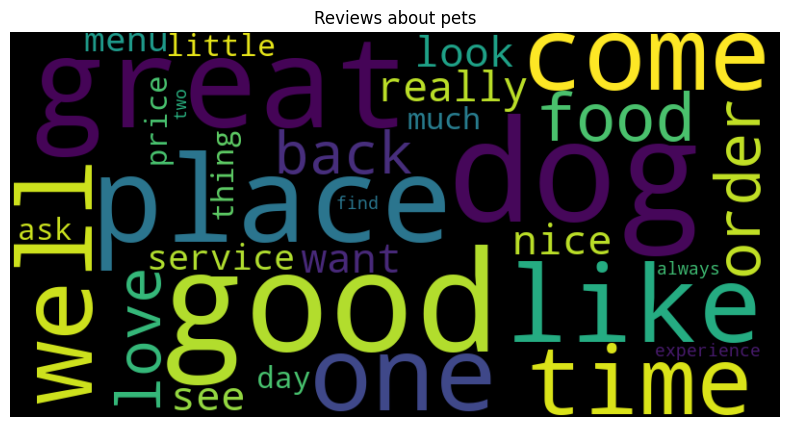

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import polars as pl

nltk.download('stopwords')

#df = pl.read_csv("../data/processed/data_pet_booking.csv")
df = pl.read_csv("../data/processed/data_pet_yelp.csv")
# --- 1. Exemple de corpus de reviews ---
reviews = df.select("text").to_series().to_list()

# --- 2. Combiner toutes les reviews en une seule chaîne ---
text = " ".join(reviews)

# --- 3. Définir les mots à ignorer (stopwords) ---
stop_words = set(stopwords.words('english'))

# Add supplementary words
custom_stopwords = {"get", "could", "take", "know", "make", "go", "give", "would", "also", "even", "say", "try"}
stop_words.update(custom_stopwords)

# --- 4. Créer le Word Cloud ---
wordcloud = WordCloud(width=800, height=400,
                      background_color='black',
                      stopwords=stop_words,
                      max_words=30).generate(text)

# --- 5. Afficher le Word Cloud ---
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Reviews about pets")
plt.show()


# modèle BERT

In [1]:
import torch
print(torch.__version__)

2.9.0+cpu


In [2]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\emma\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


## Classification avec RoBERTa

In [12]:
import torch
from transformers import pipeline
import polars as pl

# Charger un modèle adapté (RoBERTa est très bon ici)
pipe = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

# Tes labels
labels = ["pet", "child", "handicap", "other"]

# Exemple de reviews
df = pl.read_csv("../data/processed/data_handicap_booking.csv")
# --- 1. Exemple de corpus de reviews ---
reviews = df.select("review_negative").head(5).to_series().to_list()

# Classification
for r in reviews:
    result = pipe(r, candidate_labels=labels, multi_label=False)
    print(f"\nTexte : {r}")
    print(f"→ Catégorie prédite : {result['labels'][0]} (score={result['scores'][0]:.3f})")


Device set to use cpu



Texte : variety of option on dinner menu be repetitive , but tasty and well do . would prefer more salad option .
→ Catégorie prédite : other (score=0.532)

Texte : it could&#39;ve be well if they have free breakfast . my partner didn&#39;t enjoy his breakfast as he get serve with fatty bacon . no elevator . although we didn&#39;t mind that they don&#39;t have elevator , there be a time when we wish they have after hour of activity outside and go up the stair be exhausting . no hand and face towel . but those be only minor thing . we would still come back to this place .
→ Catégorie prédite : handicap (score=0.639)

Texte : the boxed breakfast could be improve
→ Catégorie prédite : other (score=0.466)

Texte : everything be great . it would have be good to have an elevator for heavy bag but not a big issue give all the other thing that be wonderful
→ Catégorie prédite : other (score=0.826)

Texte : only 1 lift work so have to wait long than usual .
→ Catégorie prédite : handicap (scor

## Translation

In [11]:
from deep_translator import GoogleTranslator

translated = GoogleTranslator(source='auto', target='en').translate("albin cat faire à manger et il sera avec son chien") 
print(translated)

albin cat make food and he will be with his dog


In [16]:
# Parallel translation

import polars as pl
from deep_translator import GoogleTranslator
from concurrent.futures import ThreadPoolExecutor, as_completed

df = pl.read_csv("../data/original/Booking/val.csv")

texts = df["review_positive"].head(50).to_list()

translator = GoogleTranslator(source='auto', target='en')

def translate_one(t):
    try:
        return translator.translate(t)
    except Exception as e:
        return f"[ERROR: {e}]"

# Parallelisation (ex: 8 threads)
with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(translate_one, texts))

df_result = pl.DataFrame({
    "translated_text": results
})

print(df_result.head())


shape: (5, 1)
┌─────────────────────────────────┐
│ translated_text                 │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ This motel is in the Center of… │
│ Close to the station and withi… │
│ Excellent customer service, gr… │
│ Incredible staff, convenient l… │
│ Incredible staff, convenient l… │
└─────────────────────────────────┘


In [26]:
# 1. Compter combien de fois chaque review apparaît par dataset
df_counts = (
    df.group_by(["original_dataset", "review"])
      .agg(pl.len().alias("count"))
)

# 2. Filtrer pour ne garder que les reviews qui apparaissent plus d'une fois
df_duplicates = df_counts.filter(pl.col("count") > 1)

# 3. Résumer : total de doublons par dataset
df_summary = (
    df_duplicates.group_by("original_dataset")
                 .agg(pl.sum("count").alias("total_duplicates"))
                 .sort("original_dataset")
)

print(df_summary)


shape: (12, 2)
┌────────────────────────────────┬──────────────────┐
│ original_dataset               ┆ total_duplicates │
│ ---                            ┆ ---              │
│ str                            ┆ u32              │
╞════════════════════════════════╪══════════════════╡
│ data_activities_reviews        ┆ 789              │
│ data_airline_reviews_1         ┆ 18               │
│ data_airline_reviews_2         ┆ 2                │
│ data_booking                   ┆ 532183           │
│ data_european_hotel_reviews    ┆ 20321            │
│ …                              ┆ …                │
│ data_hotel_reviews_2           ┆ 31               │
│ data_hotel_reviews_3           ┆ 444              │
│ data_restaurant_reviews_1      ┆ 8                │
│ data_restaurant_reviews_2      ┆ 735              │
│ data_tripadvisor_hotel_reviews ┆ 1970             │
└────────────────────────────────┴──────────────────┘


In [29]:
import polars as pl

# 1️⃣ Supprimer les reviews vides
df_non_empty = df.filter(pl.col("review").str.strip_chars() != "")

# 2️⃣ Compter les occurrences de chaque review par dataset
df_counts = (
    df_non_empty.group_by(["review", "original_dataset"])
                .agg(pl.len().alias("count"))
)

# 3️⃣ Pour chaque review, trouver le dataset où elle apparaît le plus
df_max_dataset = (
    df_counts.sort(["review", "count"], descending=[False, True])
             .group_by("review")
             .agg([
                 pl.first("original_dataset").alias("most_common_dataset"),
                 pl.max("count").alias("max_count")
             ])
)

print(df_max_dataset)


shape: (2_811_719, 3)
┌─────────────────────────────────┬────────────────────────┬───────────┐
│ review                          ┆ most_common_dataset    ┆ max_count │
│ ---                             ┆ ---                    ┆ ---       │
│ str                             ┆ str                    ┆ u32       │
╞═════════════════════════════════╪════════════════════════╪═══════════╡
│                                 ┆ data_airline_reviews_2 ┆ 1         │
│  Brisbane to Dubai. We were …   ┆                        ┆           │
│                                 ┆ data_airline_reviews_2 ┆ 1         │
│ A disappointing start to our…   ┆                        ┆           │
│                                 ┆ data_airline_reviews_2 ┆ 1         │
│ Athens to Tokyo via Dubai wi…   ┆                        ┆           │
│                                 ┆ data_airline_reviews_2 ┆ 1         │
│ Brisbane to Singapore on the…   ┆                        ┆           │
│                            

In [32]:
max_value = df_max_dataset.select(pl.max("max_count")).item()
df_max_dataset.filter(pl.col("max_count") == max_value)


review,most_common_dataset,max_count
str,str,u32
"""No Negative Location""","""data_european_hotel_reviews""",1009


In [37]:
top5 = df_max_dataset.sort("max_count", descending=True).head(15)

print(top5)

shape: (15, 3)
┌──────────────────────────────┬─────────────────────────────┬───────────┐
│ review                       ┆ most_common_dataset         ┆ max_count │
│ ---                          ┆ ---                         ┆ ---       │
│ str                          ┆ str                         ┆ u32       │
╞══════════════════════════════╪═════════════════════════════╪═══════════╡
│ No Negative  Location        ┆ data_european_hotel_reviews ┆ 1009      │
│  Nothing  Everything         ┆ data_european_hotel_reviews ┆ 940       │
│ No Negative  Everything      ┆ data_european_hotel_reviews ┆ 593       │
│ No Negative  Great location  ┆ data_european_hotel_reviews ┆ 256       │
│ good                         ┆ data_restaurant_reviews_2   ┆ 237       │
│ …                            ┆ …                           ┆ …         │
│ No Negative  Location        ┆ data_european_hotel_reviews ┆ 133       │
│  Everything  Nothing         ┆ data_european_hotel_reviews ┆ 127       │
│ No Negat

## Language identification

In [ ]:
from transformers import pipeline

text = [
    "Brevity is the soul of wit.",
    "Amor, ch'a nullo amato amar perdona."
]

model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)
pipe(df, top_k=1, truncation=True)

Device set to use cpu


[[{'label': 'en', 'score': 0.8889272212982178}],
 [{'label': 'it', 'score': 0.9120122790336609}]]

In [7]:
import polars as pl
df = pl.read_csv("../data/processed/all_reviews.csv")

In [8]:
texts = df.select("review").head(10)["review"].to_list()
pipe(texts, top_k =1, truncation = True)

[[{'label': 'en', 'score': 0.6080841422080994}],
 [{'label': 'en', 'score': 0.9144412875175476}],
 [{'label': 'en', 'score': 0.9926619529724121}],
 [{'label': 'en', 'score': 0.98438960313797}],
 [{'label': 'en', 'score': 0.8990529179573059}],
 [{'label': 'en', 'score': 0.9869490265846252}],
 [{'label': 'en', 'score': 0.9914121627807617}],
 [{'label': 'en', 'score': 0.9939849972724915}],
 [{'label': 'en', 'score': 0.9944918155670166}],
 [{'label': 'en', 'score': 0.9942750334739685}]]

In [25]:
from transformers import pipeline
import polars as pl

# Charger le modèle de détection de langue
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

df = df.head(1000)

# 1️⃣ Convertir la colonne Polars en liste Python
texts = df.select("review")["review"].to_list()

# 2️⃣ Appliquer le pipeline
results = pipe(texts, top_k=1, truncation=True)

# 3️⃣ Extraire les labels dominants
langs = [r[0]["label"] for r in results]

# 4️⃣ Ajouter les résultats dans le DataFrame Polars
df = df.with_columns(pl.Series("detected_lang", langs))

# 5️⃣ Compter le nombre de textes par langue
counts = df.group_by("detected_lang").agg(
    pl.len().alias("nb_texts")
)

print(counts)


Device set to use cpu


shape: (9, 2)
┌───────────────┬──────────┐
│ detected_lang ┆ nb_texts │
│ ---           ┆ ---      │
│ str           ┆ u32      │
╞═══════════════╪══════════╡
│ hi            ┆ 2        │
│ th            ┆ 1        │
│ nl            ┆ 1        │
│ ur            ┆ 2        │
│ sw            ┆ 1        │
│ tr            ┆ 1        │
│ pt            ┆ 3        │
│ it            ┆ 2        │
│ en            ┆ 987      │
└───────────────┴──────────┘


In [26]:
from transformers import pipeline
import polars as pl
from tqdm import tqdm  # barre de progression

# Charger le modèle
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

df = df.head(1000)

# Paramètre : taille de batch
batch_size = 100

all_langs = []
num_rows = df.height

# 1️⃣ Traitement par batch avec barre de progression
for i in tqdm(range(0, num_rows, batch_size), desc="Détection de langue"):
    batch_texts = df[i:i+batch_size, "review"].to_list()
    batch_results = pipe(batch_texts, top_k=1, truncation=True)
    batch_langs = [r[0]["label"] for r in batch_results]
    all_langs.extend(batch_langs)

# 2️⃣ Ajouter la colonne détectée au DataFrame
df = df.with_columns(pl.Series("detected_lang", all_langs))

# 3️⃣ Compter le nombre de textes par langue
counts = df.group_by("detected_lang").agg(
    pl.len().alias("nb_texts")
).sort("nb_texts", descending=True)

print(counts)


Device set to use cpu
Détection de langue: 100%|██████████| 10/10 [01:44<00:00, 10.42s/it]

shape: (9, 2)
┌───────────────┬──────────┐
│ detected_lang ┆ nb_texts │
│ ---           ┆ ---      │
│ str           ┆ u32      │
╞═══════════════╪══════════╡
│ en            ┆ 987      │
│ pt            ┆ 3        │
│ ur            ┆ 2        │
│ it            ┆ 2        │
│ hi            ┆ 2        │
│ nl            ┆ 1        │
│ sw            ┆ 1        │
│ th            ┆ 1        │
│ tr            ┆ 1        │
└───────────────┴──────────┘


In [3]:
# Multi threading test
from transformers import pipeline
import polars as pl
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Charger le modèle
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

# Exemple : on limite à 1000 lignes pour le test
df = df.head(1000)

# Paramètres
batch_size = 100
num_threads = 4  # nombre de threads à utiliser

# Fonction pour traiter un batch de textes
def process_batch(batch_texts):
    results = pipe(batch_texts, top_k=1, truncation=True)
    return [r[0]["label"] for r in results]

# 1️⃣ Créer les batches
batches = [df[i:i+batch_size, "review"].to_list() for i in range(0, df.height, batch_size)]

all_langs = []

# 2️⃣ Multithreading avec ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # soumettre tous les batches
    futures = {executor.submit(process_batch, batch): batch for batch in batches}

    # récupération des résultats avec barre de progression
    for future in tqdm(as_completed(futures), total=len(futures), desc="Détection de langue"):
        batch_langs = future.result()
        all_langs.extend(batch_langs)

# 3️⃣ Ajouter la colonne détectée au DataFrame
df = df.with_columns(pl.Series("detected_lang", all_langs))

# 4️⃣ Compter le nombre de textes par langue
counts = df.group_by("detected_lang").agg(
    pl.len().alias("nb_texts")
).sort("nb_texts", descending=True)

print(counts)


Device set to use cpu
Détection de langue: 100%|██████████| 10/10 [01:39<00:00,  9.91s/it]

shape: (9, 2)
┌───────────────┬──────────┐
│ detected_lang ┆ nb_texts │
│ ---           ┆ ---      │
│ str           ┆ u32      │
╞═══════════════╪══════════╡
│ en            ┆ 987      │
│ pt            ┆ 3        │
│ hi            ┆ 2        │
│ it            ┆ 2        │
│ ur            ┆ 2        │
│ sw            ┆ 1        │
│ nl            ┆ 1        │
│ th            ┆ 1        │
│ tr            ┆ 1        │
└───────────────┴──────────┘


In [ ]:
# test avec langid pour accelerer le processus
import polars as pl
import langid
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Fonction pour identifier la langue d'une review
def detect_lang(text):
    if not isinstance(text, str) or not text.strip():
        return None
    lang, score = langid.classify(text)
    return lang

# Paramètres
num_threads = 4  # nombre de threads à utiliser
texts = df["review"].to_list()

# 1️⃣ Parallelisation avec ThreadPoolExecutor
all_langs = []
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # tqdm pour la barre de progression
    for result in tqdm(executor.map(detect_lang, texts), total=len(texts), desc="Détection de langue"):
        all_langs.append(result)

# 2️⃣ Ajouter la colonne détectée au DataFrame Polars
df = df.with_columns(pl.Series("detected_lang", all_langs))

# 3️⃣ Compter le nombre de textes par langue
counts = df.group_by("detected_lang").agg(
    pl.len().alias("nb_texts")
).sort("nb_texts", descending=True)

print(counts)


Détection de langue:   2%|▏         | 57396/3363667 [02:10<2:04:50, 441.37it/s]


## Méthode pour accelerer encore plus les processus ( a regarder)

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import polars as pl
import langid
from tqdm import tqdm

def detect_language_parallel_optimized(df: pl.DataFrame, column_name: str, num_processes: int = None, batch_size: int = 50000) -> pl.DataFrame:
    """
    Detect the language of a text column in a Polars DataFrame using langid in parallel with ProcessPoolExecutor and batching.

    Args:
        df (pl.DataFrame): Input DataFrame.
        column_name (str): Name of the text column to process.
        num_processes (int): Number of processes to use for parallel processing (default: all available cores).
        batch_size (int): Number of rows per batch (default=50_000).

    Returns:
        pl.DataFrame: New DataFrame with an added column 'detected_lang' containing language codes.
    """
    if num_processes is None:
        import multiprocessing
        num_processes = multiprocessing.cpu_count()

    def detect_lang(texts):
        """Detect language for a list of texts."""
        return [langid.classify(t)[0] if isinstance(t, str) and t.strip() else None for t in texts]

    all_langs = []

    for i in tqdm(range(0, df.height, batch_size), desc="Language detection (batched)"):
        batch_texts = df[i:i+batch_size, column_name].to_list()
        with ProcessPoolExecutor(max_workers=num_processes) as executor:
            # submit one batch to a process
            future = executor.submit(detect_lang, batch_texts)
            all_langs.extend(future.result())

    # Return new DataFrame with added column
    return df.with_columns(pl.Series("detected_lang", all_langs))


## LDA

LDA est un modèle bayésien qui décompose un corpus en topics latents, chacun représenté par un ensemble de mots, et attribue à chaque document une proportion de ces topics. C’est l’outil classique pour le topic modeling non supervisé.


In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import pyLDAvis
import polars as pl

# --- 0. Préparation nltk ---
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- 1. Corpus exemple ---
df = pl.read_csv("../data/processed/key_word_test_a_supprimer.csv")
df = df.head(50)
documents = df["review"].to_list()


# --- 2. Nettoyage et tokenisation ---
def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

texts = [preprocess(doc) for doc in documents]

# --- 3. Créer le dictionnaire et corpus pour LDA ---
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# --- 4. Entraîner le modèle LDA ---
num_topics = 3  # on suppose 2 topics dans ce corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=15)

# --- 5. Afficher les topics ---
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# --- 6. Visualisation interactive ---
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.show(vis)  # ouvrira une page web interactive


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0: 0.015*"book" + 0.009*"get" + 0.009*"good" + 0.008*"great" + 0.007*"buy" + 0.007*"time" + 0.006*"could" + 0.006*"read" + 0.006*"would" + 0.006*"life"
Topic 1: 0.011*"cd" + 0.010*"get" + 0.010*"great" + 0.009*"good" + 0.009*"like" + 0.008*"lift" + 0.007*"album" + 0.007*"well" + 0.006*"say" + 0.006*"love"
Topic 2: 0.010*"lift" + 0.008*"like" + 0.008*"way" + 0.008*"great" + 0.008*"book" + 0.007*"good" + 0.007*"character" + 0.005*"well" + 0.005*"find" + 0.005*"write"


OSError: [Errno 22] Invalid argument: 'https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.4.0/pyLDAvis/js/ldavis.v1.0.0.css'

In [2]:
import pyLDAvis
pyLDAvis.display(vis)

Resultat style mais inutile